# HPC Mini-Challenge 2 - Beschleunigung in Data Science
## Teil 2: GPU
#### FHNW - FS22

Original von S. Suter, angepasst für das HS22 von S. Marcin

Abgabe von: <font color='blue'>Name hier eintragen</font>

#### Ressourcen
* [Überblick GPU Programmierung](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Vorlesungen und Beispiele aus dem Informatikkurs PAC (parallel computing), siehe resourcen
* CSCS "High-Performance Computing with Python" Kurs, Tag 3: 
    - JIT Numba GPU 1 + 2
    - https://youtu.be/E4REVbCVxNQ
    - https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
    - Siehe auch aktuelles Tutorial von 2021
* [Google CoLab](https://colab.research.google.com/) oder ggf. eigene GPU.


In [1]:
#!pip install numba

In [2]:
# Dummy Beispiel zum testen mit Numba

import math
from numba import vectorize
import numpy as np

@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)
  

a = np.arange(4096,dtype=np.float32)
gpu_sqrt(a)

d:\dev\hpc-m2\.venv\lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 0.       ,  1.       ,  1.4142135, ..., 63.97656  , 63.98437  ,
       63.992188 ], dtype=float32)

### 5 GPU Rekonstruktion

Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting. Code aus dem ersten Teil darf dabei verwendet werden. Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind. Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein. Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden. Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst. Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest.

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)

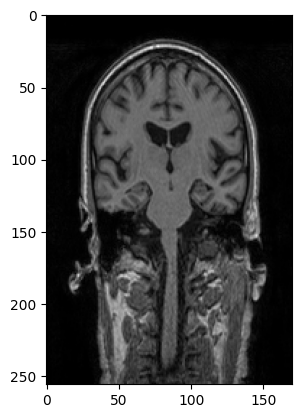

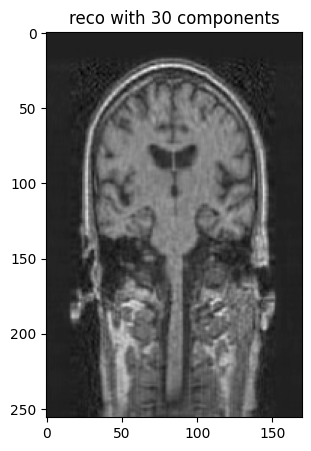

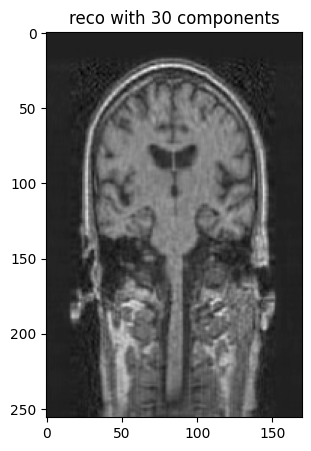

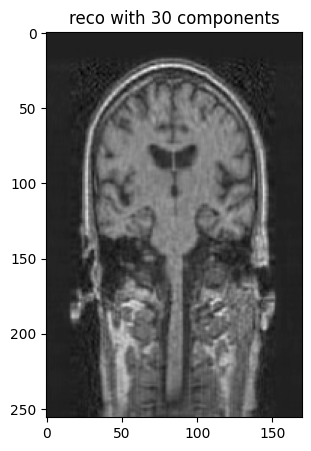

In [3]:
### BEGIN SOLUTION
import os
import imageio.v2 as imageio
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt


image_path = "./adni_png/001/m4-2_slice145.png"
image_brain = imageio.imread(image_path)

plt.imshow(image_brain, cmap='gray')

# normalize data
image_brain = image_brain - image_brain.min() / image_brain.max() - image_brain.min() 

# compute SVD
u,s,vt = np.linalg.svd(image_brain, full_matrices=False)


## helper function to plot reconstructed image
def plot_reco(reco, k):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(reco,cmap='gray')
    ax.set_title('reco with ' + str(k)+ ' components')


## reconstruct image
k = 30  # Number of components to keep
k = 30  # Number of components to keep
u_gpu = cp.asarray(u)
s_gpu = cp.asarray(s)
vt_gpu = cp.asarray(vt)


# different variants not using a kernel
def reconstruct_svd_cp(u, s, vt, k):
    return cp.dot(u[:, :k], cp.dot(cp.diag(s[:k]), vt[:k, :]))

def reconstruct_svd_cp_einsum(u, s, vt, k):
    return cp.einsum('ij,j,jk', u[:, :k], s[:k], vt[:k, :])

def reconstruct_svd_cp_broadcast(u, s, vt, k):
    return cp.dot(u[:, :k], cp.multiply(s[:k].reshape(-1, 1), vt[:k, :]))

## validate results by plotting
plot_reco(cp.asnumpy(reconstruct_svd_cp(u_gpu, s_gpu, vt_gpu, k)), k)
plot_reco(cp.asnumpy(reconstruct_svd_cp_einsum(u_gpu, s_gpu, vt_gpu, k)), k)
plot_reco(cp.asnumpy(reconstruct_svd_cp_broadcast(u_gpu, s_gpu, vt_gpu, k)), k)

### END SOLUTION

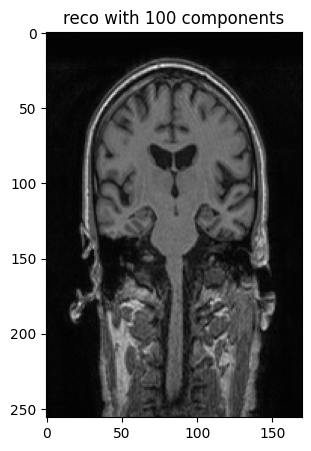

In [3]:
kernel_code = """
extern "C" __global__
void reconstruct_svd(const float* u, const float* s, const float* vt, float* C,
            int rows_u, int cols_u, int rows_vt, int cols_vt, int k)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i < rows_u && j < cols_vt) {
        float sum = 0;
        for (int l = 0; l < k; ++l) {
            sum += u[i * cols_u + l] * s[l] * vt[l * cols_vt + j];
        }
        C[i * cols_vt + j] = sum;
    }
}
"""

reconstruct_svd_kernel = cp.RawKernel(kernel_code, 'reconstruct_svd')

u, s, vt = np.linalg.svd(image_brain, full_matrices=False)
k = 100
C = np.zeros((u.shape[0], vt.shape[1]), dtype=np.float32)

u_gpu = cp.asarray(u, dtype=np.float32)
s_gpu = cp.asarray(s, dtype=np.float32)
vt_gpu = cp.asarray(vt, dtype=np.float32)
C_gpu = cp.asarray(C, dtype=np.float32)

threads_per_block = (16, 16)
blocks_per_grid_x = math.ceil(u.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(vt.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

reconstruct_svd_kernel(blocks_per_grid, threads_per_block, (u_gpu, s_gpu, vt_gpu, C_gpu, u.shape[0], u.shape[1], vt.shape[0], vt.shape[1], k))

C = cp.asnumpy(C_gpu)

plot_reco(C, k)

In [5]:
# measure time
import timeit

print(timeit.timeit('reconstruct_svd_kernel(blocks_per_grid, threads_per_block, (u_gpu, s_gpu, vt_gpu, C_gpu, u.shape[0], u.shape[1], vt.shape[0], vt.shape[1], k))', globals=globals(), number=1000))

print(timeit.timeit('reconstruct_svd_cp(u_gpu, s_gpu, vt_gpu, k)', globals=globals(), number=1000))

print(timeit.timeit('reconstruct_svd_cp_einsum(u_gpu, s_gpu, vt_gpu, k)', globals=globals(), number=1000))

print(timeit.timeit('reconstruct_svd_cp_broadcast(u_gpu, s_gpu, vt_gpu, k)', globals=globals(), number=1000))


0.022324799999978495
0.35156609999989996
0.37664360000007946
0.10071190000007846


<font color='blue'>Antwort hier eingeben</font>

Wann ich CuPy oder Numba verwenden würde:
- CuPy:
 - Wenn der Code schon vekoetisiert ist (z.B. mit numpy)
 - und ich den Code nicht gross anpassen will (da CuPy ein drop-in replacement für numpy ist)
- Numba:
  - Wenn der Code noch nicht vektorisiert ist (z.B. enthält for loops) und der Code deshalb kompileriert werden muss. 

#### 5.2 GPU-Kernel Performance

##### 5.3.1 Blocks und Input-Grösse

Links: 
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA Kapitel zu "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Grösse der Input-Daten durch. Erstelle dafür ein neues Datenset mit beliebig grossen Matrizen, da die GPU besonders geeignet ist um grosse Inputs zu verarbeiten (Verwende diese untschiedlich grossen Matrizen für alle nachfolgenden Vergeliche und Tasks ebenfalls). Messe die Performance des GPU-Kernels mittels geeigneten Funktionen. Welche Blockgrösse in Abhängigkeit mit der Input-Grösse hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen? Welches sind deiner Meinung nach die Gründe dafür? Wie sind die Performance Unterschiede zwischen deiner CPU und GPU Implementierung? Diskutiere deine Analyse (ggf. mit Grafiken).

In [6]:
# create new test matrices
import random
from tqdm import tqdm

test_image_1 = np.random.rand(random.randint(800, 1000), random.randint(800, 1000))
test_image_2 = np.random.rand(random.randint(2000, 2500), random.randint(2000, 2500))
test_image_3 = np.random.rand(random.randint(4000, 4500), random.randint(4000, 4500))
# huge_image = np.random.rand(8192, 8192)


images = {
    'test_image_1': test_image_1,
    'test_image_2': test_image_2,
    'test_image_3': test_image_3,
    # 'huge_image': huge_image
}

decompositions = {}
for name, image in tqdm(images.items()):
    # move image to gpu
    image_gpu = cp.asarray(image, dtype=np.float32)
    u_gpu, s_gpu, vt_gpu = cp.linalg.svd(image_gpu, full_matrices=False)

    u = cp.asnumpy(u_gpu)
    s = cp.asnumpy(s_gpu)
    vt = cp.asnumpy(vt_gpu)

    # release memory
    del u_gpu, s_gpu, vt_gpu, image_gpu

    decompositions[name] = {
        'u': u,
        's': s,
        'vt': vt
    }

100%|██████████| 3/3 [00:29<00:00,  9.98s/it]


In [7]:
### BEGIN SOLUTION
from cupyx.profiler import benchmark


def measure_kernel_reconstruction(threads_per_block, decomposed_image):
    u, s, vt = decomposed_image['u'], decomposed_image['s'], decomposed_image['vt']
    k = min(u.shape[1], vt.shape[0])

    blocks_per_grid_x = math.ceil(u.shape[0] / threads_per_block[0])
    blocks_per_grid_y = math.ceil(vt.shape[1] / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    u_gpu = cp.asarray(u, dtype=np.float32)
    s_gpu = cp.asarray(s, dtype=np.float32)
    vt_gpu = cp.asarray(vt, dtype=np.float32)
    C_gpu = cp.zeros((u.shape[0], vt.shape[1]), dtype=np.float32)

    try:
        return benchmark(reconstruct_svd_kernel, (blocks_per_grid, threads_per_block, (u_gpu, s_gpu, vt_gpu, C_gpu, u.shape[0], u.shape[1], vt.shape[0], vt.shape[1], k)), n_repeat=10)
    except:
        return f"error with threads_per_block: {threads_per_block} -"

for image in decompositions.keys():
    for i in range(2, 6):
        threads_per_block = (2**i, 2**i)
        print(image, "-", threads_per_block, "-", measure_kernel_reconstruction(threads_per_block, decompositions[image]))
### END SOLUTION

test_image_1 - reconstruct_svd     :    CPU:    55.440 us   +/- 16.245 (min:    30.600 / max:    83.800) us     GPU-0: 10356.941 us   +/- 572.414 (min:  9851.904 / max: 11894.784) us
test_image_1 - reconstruct_svd     :    CPU:    48.410 us   +/- 19.795 (min:    22.400 / max:    80.200) us     GPU-0:  9063.424 us   +/- 312.926 (min:  8638.464 / max:  9546.752) us
test_image_1 - reconstruct_svd     :    CPU:    63.270 us   +/- 14.965 (min:    35.500 / max:    89.000) us     GPU-0: 13576.806 us   +/- 724.854 (min: 12760.064 / max: 15141.888) us
test_image_1 - reconstruct_svd     :    CPU:    71.200 us   +/- 18.229 (min:    43.000 / max:   117.900) us     GPU-0: 21910.630 us   +/- 365.587 (min: 21393.408 / max: 22629.375) us
test_image_2 - reconstruct_svd     :    CPU:    82.850 us   +/- 15.879 (min:    63.100 / max:   108.600) us     GPU-0: 166956.238 us   +/- 1068.535 (min: 165605.377 / max: 169543.686) us
test_image_2 - reconstruct_svd     :    CPU:    94.070 us   +/- 29.460 (min:    6

<font color='blue'>Antwort hier eingeben</font>

##### 5.2.2 Shared Memory auf der GPU
Optimiere deine Implementierung von oben indem du das shared Memory der GPU verwendest. Führe wieder mehrere Experimente mit unterschiedlicher Datengrösse durch und evaluiere den Speedup gegenüber der CPU Implementierung.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplikation und Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

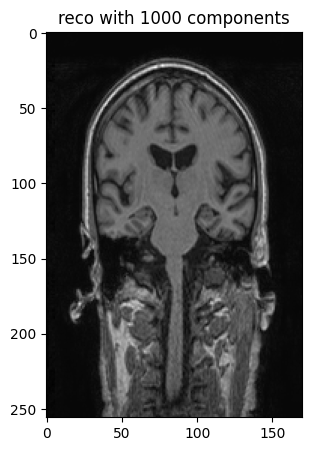

In [60]:
### BEGIN SOLUTION
from numba import cuda, float32

@cuda.jit
def reconstruct_svd_numba(u, s, vt, C, k):
    i, j = cuda.grid(2)
    if i < u.shape[0] and j < vt.shape[1]:
        sum = 0
        for l in range(k):
            sum += u[i, l] * s[l] * vt[l, j]
        C[i, j] = sum

TBP = 16

@cuda.jit
def reconstruct_svd_numba_shared_memory(u, s, vt, C, k):
    """
    This kernel uses shared memory to speed up the computation.
    
    :param u: u matrix
    :param s: s vector
    :param vt: vt matrix
    :param C: result matrix
    :param k: number of components to keep
    """
    block_i = cuda.blockIdx.x
    block_j = cuda.blockIdx.y
    thread_i = cuda.threadIdx.x
    thread_j = cuda.threadIdx.y
    i, j = cuda.grid(2)

    num_blocks = math.ceil(min(k, u.shape[1]) / TBP)
    for m in range(num_blocks):
        u_shared = cuda.shared.array(shape=(TBP, TBP), dtype=float32)
        vt_shared = cuda.shared.array(shape=(TBP, TBP), dtype=float32)
        s_shared = cuda.shared.array(shape=(TBP), dtype=float32)

        u_shared[thread_i, thread_j] = u[block_i * TBP + thread_i, m * TBP + thread_j]
        vt_shared[thread_i, thread_j] = vt[m * TBP + thread_i, block_j * TBP + thread_j]
        if thread_j == 0:
            s_shared[thread_i] = s[m * TBP + thread_i]

        cuda.syncthreads()
        for l in range(TBP):
            if l + m * TBP < k:
                C[i, j] += u_shared[thread_i, l] * s_shared[l] * vt_shared[l, thread_j]
        cuda.syncthreads()



u, s, vt = np.linalg.svd(image_brain, full_matrices=False)

u_gpu = cp.asarray(u, dtype=np.float32)
s_gpu = cp.asarray(s, dtype=np.float32)
vt_gpu = cp.asarray(vt, dtype=np.float32)
C_gpu = cp.zeros((u.shape[0], vt.shape[1]), dtype=np.float32)

k = 1000

threads_per_block = (16, 16)
blocks_per_grid_x = math.ceil(u.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(vt.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

reconstruct_svd_numba_shared_memory[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k)

C = cp.asnumpy(C_gpu)
plot_reco(C, k)

### END SOLUTION

Was sind deine Erkenntnisse bzgl. GPU-Memory-Allokation und des Daten-Transferes auf die GPU? Interpretiere deine Resultate.

<font color='blue'>Antwort hier eingeben</font>

##### 5.2.3 Bonus: Weitere Optimierungen
Optimiere deine Implementation von oben weiter. Damit du Erfolg hast, muss der Data-Reuse noch grösser sein.

In [ ]:
### BEGIN SOLUTION
### END SOLUTION

#### 5.3 NVIDIA Profiler

Benutze einen Performance Profiler von NVIDIA, um Bottlenecks in deinem Code zu identifizieren bzw. unterschiedliche Implementierungen (Blocks, Memory etc.) zu vergleichen. 

* Siehe Beispiel example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) für das Profiling des Codes und die Inspektion der Ergebnisse (neuste Variante)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe, welche Bottlenecks du gefunden bzw. entschärft hast.

<font color='blue'>Antwort hier eingeben inkl. Bild.</font>

### 6 Beschleunigte Rekonstruktion mehrerer Bilder
#### 6.1 Implementierung
Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Untersuche dies auch für grössere Inputs als die MRI-Bilder.

In [ ]:
### BEGIN SOLUTION

### END SOLUTION

<font color='blue'>Antwort hier eingeben</font>

#### 6.2 Analyse
Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson.

<font color='blue'>Antwort hier eingeben</font>

#### 6.3 Komponentendiagramm

Erstelle das Komponentendiagramm dieser Mini-Challenge für die Rekunstruktion mehrere Bilder mit einer GPU-Implementierung. Erläutere das Komponentendigramm in 3-4 Sätzen.


<font color='blue'>Antwort hier eingeben inkl. Bild(ern).</font>

### 7 Reflexion

Reflektiere die folgenden Themen indem du in 3-5 Sätzen begründest und anhand von Beispielen erklärst.

1: Was sind deiner Meinung nach die 3 wichtigsten Prinzipien bei der Beschleunigung von Code?

<font color='blue'>Antwort hier eingeben</font>

2: Welche Rechenarchitekturen der Flynnschen Taxonomie wurden in dieser Mini-Challenge wie verwendet?

<font color='blue'>Antwort hier eingeben</font>

3: Haben wir es in dieser Mini-Challenge hauptsächlich mit CPU- oder IO-Bound Problemen zu tun? Nenne Beispiele.

<font color='blue'>Antwort hier eingeben</font>

4: Wie könnte diese Anwendung in einem Producer-Consumer Design konzipiert werden?

<font color='blue'>Antwort hier eingeben</font>

5: Was sind die wichtigsten Grundlagen, um mehr Performance auf der GPU in dieser Mini-Challenge zu erreichen?

<font color='blue'>Antwort hier eingeben</font>

6: Reflektiere die Mini-Challenge. Was ist gut gelaufen? Wo gab es Probleme? Wo hast du mehr Zeit als geplant gebraucht? Was hast du dabei gelernt? Was hat dich überrascht? Was hättest du zusätzlich lernen wollen? Würdest du gewisse Fragestellungen anders formulieren? Wenn ja, wie?

<font color='blue'>Antwort hier eingeben</font>